In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import math

In [3]:
h = 620
w = 620

def PxltoCoord(x, y, zoom, cntr_lat, cntr_lon):
    parallelMultiplier = math.cos(cntr_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier
    pointLat = cntr_lat - degreesPerPixelY * (y - h / 2)
    pointLng = cntr_lon + degreesPerPixelX * (x - w / 2)

    return [float(pointLat), float(pointLng)]


# Because of non linear transformation (going from pixel to coordinates), function has to be solved for X and Y
def CoordToPixel(pointLat, pointLon, test_lat, test_lon, zoom):
    parallelMultiplier = math.cos(test_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier

    Y = (test_lat - pointLat) / degreesPerPixelY + 0.5 * h
    X = (pointLon - test_lon) / degreesPerPixelX + 0.5 * w
    return X, Y

In [4]:
def find_specific_lookup(data, search_image, template_name):
    for entry in data:
        if entry["search_image"] == search_image:
            for template in entry["templates"]:
                if template["template"] == template_name:
                    return template
    return None

In [5]:
from matplotlib import image as mpimg

#get image pairs
base_path = os.path.dirname(os.getcwd())

#label path
lbl_path = os.path.join(base_path, 'Data/labels/train_template_matching.json')

#source and query images
# s_img_path = os.path.join(base_path, 'Data/map_train/51.99908_4.373749.png')
s_img_path = os.path.join(base_path, 'Data\\map_train\\51.998552_4.372891.png')
q_img_path = os.path.join(base_path, 'Data/train_template_matching')

#for now source path is constant
s_img = cv2.imread(s_img_path)

with open(lbl_path, 'r') as file:
    label = json.load(file)

images = []
templates = []
print(q_img_path)
for file in os.listdir(q_img_path):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            q_img = cv2.imread(os.path.join(q_img_path, file))
            # images.append([q_img[:, :, :3], s_img[:,:,:3]])
            gps = find_specific_lookup(label, '51.998552_4.372891.png', file)

            templates.append((q_img[:, :, :3], gps))

c:\Users\lucah\Documents\hackathon\CASSINI\Data/train_template_matching


In [6]:
def extract_features_for_templates(templates, source_image):
    feature_list = []
    label_list = []

    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)

    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)

        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)

        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        good_matches = good_matches[:100]
        # Extract matched keypoints
        query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

        # Flatten and combine features
        src_flat = query_pts.flatten()
        dst_flat = dst_pts.flatten()
        input_features = np.concatenate([src_flat, dst_flat])

        # Append to feature list
        feature_list.append(input_features)
        label_list.append(gps_pixel)  # GPS coordinates of this template image
    max_len = max(len(features) for features in feature_list)
    # max_len = 468
    padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return np.array(padded_features), np.array(label_list)


In [26]:
def extract_keypoint(template, source_image, sift):
    kp_source, des_source = sift.detectAndCompute(source_image, None)

    kp_template, des_template = sift.detectAndCompute(template[0], None)

    # gps_coords = template[1]['gps_coords']
    # gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
    # Match features
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_template, des_source, k=2)

    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    print(good_matches[0])

    good_matches = good_matches[:100]
    # Extract matched keypoints
    query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)

    return dst_pts, query_pts
        # Flatten and combine features

        # dst_flat = dst_pts.flatten()
        # input_features = np.concatenate([src_flat, dst_flat])
        #
        # # Append to feature list
        # feature_list.append(input_features)
        # label_list.append(gps_pixel)  # GPS coordinates of this template image
    # max_len = max(len(features) for features in feature_list)
    # # max_len = 468
    # padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]


In [8]:
def extract_keypoints(templates, source_image):
    feature_list = []
    label_list = []
    src_flat = []
    sift = cv2.SIFT_create()

    for template in templates:
        extract_keypoint(template, source_image, sift)

In [9]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

def cluster_keypoints(keypoints_train, cluster_alg=None):

    if cluster_alg is None:
        cluster_alg = DBSCAN(eps=0.06, min_samples=8)
    #keypoints_train = extract_keypoints(templates, s_img)
    # db = DBSCAN(eps=0.1, min_samples=8).fit(keypoints_train/620)

    clustering = cluster_alg.fit(keypoints_train/620)
    labels = clustering.labels_

    # Number of clusters in labels, ignoring noise if present.
    # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # n_noise_ = list(labels).count(-1)
    # print(n_clusters_)
    return labels

In [10]:
from collections import Counter

def retrieve_relevant_points(keypoints_train, labels):
    counter = Counter(list(filter(lambda x: x >= 0, labels)))
    if len(counter) == 0:
        return []
    largest_cluster = max(counter, key=counter.get)
    # print(f"counter: {counter}")
    # print(f"largest_cluster: {largest_cluster}")
    cluster = []
    for i in range(len(keypoints_train)):
        if labels[i] == largest_cluster:
            cluster.append(keypoints_train[i])
    return cluster

In [12]:
def get_pixel_average(coords):
    if len(coords) == 0:
        return np.array([])
    return np.average(coords, axis=0)

< cv2.DMatch 0000025904F98A50>


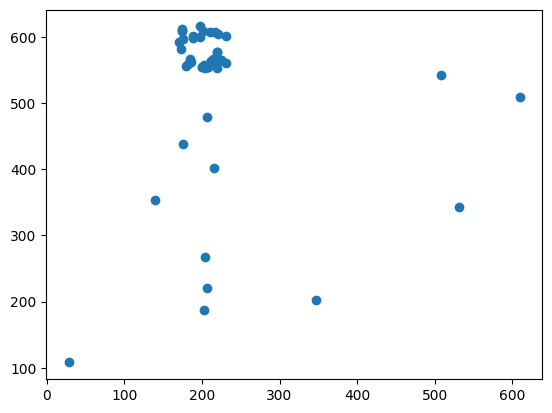

average_offset: [-35.86667  -41.770935]
maximum_difference: [491.4771 593.6255]
[ 0  0  0  0  0 -1  0 -1 -1  0  0  0  0  0  0 -1 -1  0  0 -1  0  0  0  0
  0 -1  0  0 -1 -1  0  0  0 -1  0  0  0 -1  0  0  0  0 -1  0  0  0  0]
[array([170.58417, 593.17084], dtype=float32), array([172.86496, 581.23645], dtype=float32), array([173.71753, 608.877  ], dtype=float32), array([173.71753, 608.877  ], dtype=float32), array([174.54543, 611.90125], dtype=float32), array([175.47531, 597.0568 ], dtype=float32), array([178.96616, 556.34705], dtype=float32), array([182.4758, 559.5556], dtype=float32), array([183.9473, 566.7149], dtype=float32), array([186.2068, 561.8992], dtype=float32), array([188.78871, 599.27106], dtype=float32), array([188.72156, 602.1658 ], dtype=float32), array([198.0211 , 599.79645], dtype=float32), array([197.74834, 616.0474 ], dtype=float32), array([199.83087, 555.074  ], dtype=float32), array([199.83087, 555.074  ], dtype=float32), array([201.42548, 609.63025], dtype=float32),

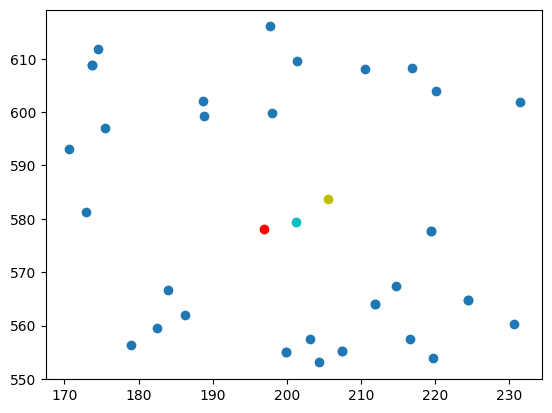

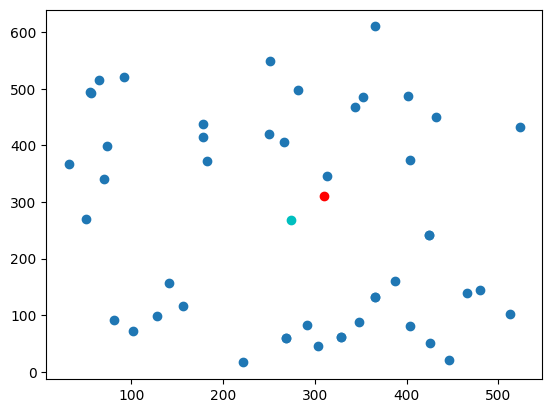

[51.991998, 4.368894] -> (196.8703004444432, 578.035561525346) -> [51.991998, 4.368894]


In [ ]:
# Testing cell!!! Throw in some random code and see what it does!

template = templates[12] # random query image
# print(template[1])

sift = cv2.SIFT_create()
keypoints_source, keypoints_query = extract_keypoint(template, s_img, sift)
# print(keypoints_source)
# print(len(keypoints_source))
plt.scatter(keypoints_source[:, 0], keypoints_source[:, 1])
plt.show()

# Calculate how much the average is offset from the center and
# the maximum difference in x and y for the query image
average_offset = np.mean(keypoints_query, axis=0) - 310
maximum_difference_query = np.max(keypoints_query, axis=0) - np.min(keypoints_query, axis=0)

print(f"average_offset: {average_offset}")
print(f"maximum_difference: {maximum_difference_query}")

# Find the cluster of keypoints in the source image that match the query image
cluster_labels = cluster_keypoints(keypoints_source)
cluster_labels_filtered = retrieve_relevant_points(keypoints_source, cluster_labels)

print(cluster_labels)
print(cluster_labels_filtered)

# Calculate the scale factor and the scaled offset via the ratio of the maximum difference
# between the cluster and query image
maximum_difference_cluster = np.max(cluster_labels_filtered, axis=0) - np.min(cluster_labels_filtered, axis=0)
scale = maximum_difference_cluster / maximum_difference_query

print(f"maximum_difference_cluster: {maximum_difference_cluster}")
print(f"scale: {scale}")

scaled_offset = average_offset * (maximum_difference_cluster / maximum_difference_query)

actual_coords = template[1]['gps_coords']
actual_pixel = CoordToPixel(actual_coords[0], actual_coords[1], 51.999080, 4.373749, 15)

cluster_pixel = get_pixel_average(cluster_labels_filtered)
cluster_pixel_corrected = cluster_pixel - scaled_offset

# Plot only the points from the cluster, together with their (corrected) average and the actual pixel value
plt.scatter(np.array(cluster_labels_filtered)[:, 0], np.array(cluster_labels_filtered)[:, 1])
plt.scatter(actual_pixel[0], actual_pixel[1], c='r')
plt.scatter(cluster_pixel[0], cluster_pixel[1], c='c')
plt.scatter(cluster_pixel_corrected[0], cluster_pixel_corrected[1], c='y')
plt.show()

# Plot the query image with its keypoints and the center of the image in red
plt.scatter(keypoints_query[:, 0], keypoints_query[:, 1])
plt.scatter(average_offset[0] + 310, average_offset[1] + 310, c='c')
plt.scatter(310, 310, c='r')
plt.show()

# Try plotting coord -> pixel -> coord, see if there's a drift
init_coords = template[1]['gps_coords']
actual_pixel = CoordToPixel(init_coords[0], init_coords[1], 51.999080, 4.373749, 15)
calculated_coords = PxltoCoord(actual_pixel[0], actual_pixel[1], 15, 51.999080, 4.373749)

print(f"{init_coords} -> {actual_pixel} -> {calculated_coords}") # seems just fine


In [ ]:
def offset_point_average(keypoints_query, keypoints_cluster, average_pixel):
    average_offset = np.mean(keypoints_query, axis=0) - 310
    # print(f"average_offset: {average_offset}")
    maximum_difference_query = np.max(keypoints_query, axis=0) - np.min(keypoints_query, axis=0)
    # print(f"maximum_difference: {maximum_difference_query}")

    maximum_difference_cluster = np.max(keypoints_cluster, axis=0) - np.min(keypoints_cluster, axis=0)
    # print(f"maximum_difference_cluster: {maximum_difference_cluster}")
    # print(f"scale: {maximum_difference_cluster / maximum_difference_query}")
    scaled_offset = average_offset * (maximum_difference_cluster / maximum_difference_query)

    # print(f"Scaled offset: {scaled_offset}")

    return average_pixel - scaled_offset

In [ ]:
from haversine import haversine, Unit


def run_matching(center_lat, center_lon, zoom, templates_used=1000, plot_graph=False, calg=None):
    # if calg is None:
    #     calg = DBSCAN(eps=0.1, min_samples=8)
    distances_meters = []
    distances_pixels = []
    # templates_selection = templates
    sift = cv2.SIFT_create()
    empty_points = 0
    distance_too_large = 0
    selected_templates = templates[:templates_used]

    for i, template in enumerate(selected_templates):
        if i % 50 == 0:
            print(f"Iteration {i}/{len(selected_templates)}; Empty points: {empty_points}; Distance too large: {distance_too_large}")

        keys_src, keys_qry = extract_keypoint(template, s_img, sift)
        labels = cluster_keypoints(keys_src, cluster_alg=calg)
        points = retrieve_relevant_points(keys_src, labels)

        if len(points) == 0:
            empty_points += 1
            # print(keys)
            # print(labels)
            # print(points)
            # print(avg_points)
            # plt.scatter(keys[:, 0], keys[:, 1])
            # plt.show()
            continue

        avg_points = get_pixel_average(points)
        avg_points = offset_point_average(keys_qry, points, avg_points) # include offset due to mean being different!

        # 51.998552_4.372891.png
        predicted_coords = PxltoCoord(avg_points[0], avg_points[1], zoom, center_lat, center_lon)
        actual_coords = template[1]['gps_coords']
        distance_meters = haversine(predicted_coords, actual_coords, unit=Unit.METERS)

        actual_pixel = CoordToPixel(actual_coords[0], actual_coords[1], center_lat, center_lon, zoom)
        # Euclidean distance
        # distance_pixel = math.sqrt((avg_points[0] - actual_pixel[0]) ** 2 + (avg_points[1] - actual_pixel[1]) ** 2)

        # Directional distance in both x and y axis are kept separately for further analysis
        distance_pixel = [avg_points[0] - actual_pixel[0], avg_points[1] - actual_pixel[1]]

        distances_meters.append(distance_meters)
        distances_pixels.append(distance_pixel)
        # if distance > 200:
        #     distance_too_large += 1
        #     if plot_graph:
        #         plt.scatter(keys[:, 0], keys[:, 1], c=labels)
        #         plt.legend()
        #         plt.scatter(avg_points[0], avg_points[1], c='r')
        #         plt.scatter(actual_pixel[0], actual_pixel[1], c='g')
        #         plt.show()
        # else:
        #     distances.append(distance)

        # print(haversine(predicted_coords, actual_coords, unit=Unit.METERS))

    return distances_meters, distances_pixels, empty_points, distance_too_large


In [ ]:
center_lat = 51.999080
center_lon = 4.373749
zoom = 15

distances_meters, disatnces_pixels, empty_points, distance_too_large = run_matching(center_lat, center_lon, zoom, 100)
disatnces_pixels = np.array(disatnces_pixels)
print()
print(f"Empty points: {empty_points}")
print(f"Distance too large: {distance_too_large}\n")

average_distance_meters = sum(distances_meters)/len(distances_meters)
print("Distance measurements in meters")
print(f"Average distance from pixel: {average_distance_meters}")
print(f"Standard deviation: {np.std(distances_meters)}\n")

print("Distance measurements in horizontal pixels")
print(f"Average distance from pixel: {sum(disatnces_pixels[:, 0])/len(disatnces_pixels)}")
print(f"Standard deviation: {np.std(disatnces_pixels[:, 0])}\n")

print("Distance measurements in vertical pixels")
print(f"Average distance from pixel: {sum(disatnces_pixels[:, 1])/len(disatnces_pixels)}")
print(f"Standard deviation: {np.std(disatnces_pixels[:, 1])}\n")

Iteration 0/100; Empty points: 0; Distance too large: 0
Iteration 50/100; Empty points: 2; Distance too large: 0

Empty points: 5
Distance too large: 0

Distance measurements in meters
Average distance from pixel: 33.12558186378367
Standard deviation: 7.133002332603957

Distance measurements in horizontal pixels
Average distance from pixel: -6.624387264251709
Standard deviation: 4.89100456237793

Distance measurements in vertical pixels
Average distance from pixel: -7.623754978179932
Standard deviation: 2.7407045364379883

